In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings
#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import c as venn
#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
%matplotlib inline




In [2]:
data = pd.read_csv('Reviews.csv')


In [3]:
data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [4]:
data.shape

(568454, 10)

This is our dataset, where we have:
    
    Id:Row Id
    ProductId:Unique identifier for the product
    UserId:Unqiue identifier for the user
    ProfileName:Profile name of the user
    HelpfulnessNumerator: Number of users who found the review helpful
    HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not
    Score: Rating between 1 and 5
    Time: Timestamp for the review
    Summary: Brief summary of the review
    Text: Text of the review

# ProductId

Let's first check how many identical Product Id is present in the dataset, I think there should be many products which are repeated as a
single product will be reviewed by multiple users.

In [5]:
data['ProductId'].nunique()

74258

In [6]:
df_prod=pd.DataFrame(data['ProductId'].value_counts()).reset_index()
df_prod.columns=['Productid','Count']
df_prod.head(10)

Productid  Count
0  B007JFMH8M    913
1  B002QWP8H0    632
2  B0026RQTGE    632
3  B002QWHJOU    632
4  B002QWP89S    632
5  B003B3OOPA    623
6  B001EO5Q64    567
7  B006HYLW32    564
8  B0013NUGDE    564
9  B0026KNQSA    564

Let's see how many product has review more than 50.

In [7]:
df_prod[df_prod['Count']>10].shape[0]

9618

Thus from above we understood that there are 74258 unique product in our dataset and out of that only 9618 products has been reviewed
more that 10 times. I will be taking 10 as threshold is future calculation too.

# UserId

In [8]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [9]:
data['UserId'].nunique(),data.shape[0]

(256059, 568454)

Thus there are only 2.5L users out of 5.68L reviews, which means a user has given more than one review for more than one product.

But first lets check if ther is any duplicate entry. i:e same product id  having same review from same user id.

In [10]:
data[data.duplicated(['UserId','ProductId'])]

Id   ProductId          UserId                   ProfileName  \
426        427  B000G6RYNE  A1Y3XPZK9ZADFW                    albinocrow   
429        430  B000G6RYNE  A1IRN1M05TPOVT  Sharon M. Helfand "Scrapper"   
435        436  B000G6RYNE  A15USNEAJUXOSH                    L. Schrank   
467        468  B000G6RYNE  A3PJZ8TU8FDQ1K                  Jared Castle   
485        486  B000G6RYNE  A31N6KB160O508                       Fran W.   
486        487  B000G6RYNE  A31N6KB160O508                       Fran W.   
489        490  B000G6RYNE  A1B05INWIDZ74O                   M. A. Ramos   
503        504  B000G6RYNE  A2OEUROGZDTXUJ                     J. Graves   
540        541  B000G6RYNE  A3RMGIKUWGPZOK                Jean Visnefski   
571        572  B000G6RYNE  A3RMGIKUWGPZOK                Jean Visnefski   
574        575  B000G6RYNE  A3PJZ8TU8FDQ1K                  Jared Castle   
587        588  B000G6RYNE  A2OEUROGZDTXUJ                     J. Graves   
589        590  B000G6RYNE  A2NO1TXXS9T0EE                  BruteNStones   
600        601  B000G6RYNE  A3RMGIKUWGPZOK                Jean Visnefski   
602        603  B000G6RYNE  A3PJZ8TU8FDQ1K                  Jared Castle   
603        604  B000G6RYNE  A3PJZ8TU8FDQ1K                  Jared Castle   
622        623  B000G6RYNE   ADS5APY1NKTL4                D. Pawl "Dani"   
900        901  B000ER6YO0  A3NHUQ33CFH3VM                  Citizen John   
901        902  B000ER6YO0  A3NHUQ33CFH3VM                  Citizen John   
903        904  B000ER6YO0  A3NHUQ33CFH3VM                  Citizen John   
923        924  B000ER6YO0   AWBKE3QTB3BWX                        Nessie   
924        925  B000ER6YO0   ACM3Z9NLSE8S9                         Tracy   
928        929  B000ER6YO0  A2NQKBC54RAZL5                      Keribeth   
944        945  B000ER6YO0   A6LAMY7Z10BBJ                Amazon Shopper   
945        946  B000ER6YO0   ATIHDHZYNQ0EI  Kristen O'donnell "twinsmom"   
1086      1087  B0030N5K1I  A2058UP7ATXFOF               Patrick T. Long   
1087      1088  B0030N5K1I  A19U4T4I7UZGNM                        3 dogs   
1216      1217  B005O072PC  A37REIKYSHU4ZF                 Miles Hiniker   
2336      2337  B0001FQVCK   A5D06XJHDXK75                         C. Po   
2624      2625  B0016FY6H6   APD719S590F2U              Erin E "tornado"   
...        ...         ...             ...                           ...   
567868  567869  B005K4Q68Q   ALD467ZEFBPDF               DenDen "Dennis"   
567884  567885  B005K4Q68Q  A2ALSH7ZYSVPK3                       dopey62   
567935  567936  B0030VJ8YU  A1S6HK2R1KUC5E                      data1701   
567943  567944  B0030VJ8YU  A2IRI9FQ3Y2THO                     MomHaydee   
567947  567948  B0030VJ8YU  A3FIV3X7H4VLI7                         mandm   
567948  567949  B0030VJ8YU  A3FIV3X7H4VLI7                         mandm   
567957  567958  B0030VJ8YU   A2MF0C4E7GYCI                       VW "VW"   
567958  567959  B0030VJ8YU   A2MF0C4E7GYCI                       VW "VW"   
567970  567971  B0030VJ8YU   A90I4J49NU3XN                         Amy W   
567975  567976  B0030VJ8YU  A2IRI9FQ3Y2THO                     MomHaydee   
567977  567978  B0030VJ8YU  A1N8YWKJVXVXKY                    buymorenow   
567983  567984  B0030VJ8YU   A4DTM6B4IBYQX                          C.O.   
567987  567988  B0030VJ8YU   AOWHV1P78VYG0                            CC   
568008  568009  B0030VJ8YU   ATIHDHZYNQ0EI  Kristen O'donnell "twinsmom"   
568012  568013  B0030VJ8YU   A4DTM6B4IBYQX                          C.O.   
568014  568015  B0030VJ8YU  A3VX9G8YEOD2XO                A. Connercoash   
568017  568018  B0030VJ8YU  A20P8VC55KPPCT                        FL Mom   
568026  568027  B0030VJ8YU  A1UFPQ3C1MI3QC                     Kate Wolf   
568031  568032  B0030VJ8YU   A5993LK5CYHAA             Alice M "Alice M"   
568034  568035  B0030VJ8YU  A1S6HK2R1KUC5E                      data1701   
568041  568042  B0030VJ8YU  A1N8YWKJVXVXKY                  

In [11]:
data[data.duplicated(['UserId','ProductId'])].shape

(7650, 10)

So there are 7650 entry which are duplicate. Let's pick one entry and check further.

In [12]:
data[(data['UserId']=='A1Y3XPZK9ZADFW')& (data['ProductId']=='B000G6RYNE')]

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
425  426  B000G6RYNE  A1Y3XPZK9ZADFW  albinocrow                     0   
426  427  B000G6RYNE  A1Y3XPZK9ZADFW  albinocrow                     0   

     HelpfulnessDenominator  Score        Time  \
425                       0      4  1334016000   
426                       0      4  1334016000   

                            Summary  \
425  glad to find them in 1 oz size   
426    pretty good, could be better   

                                                  Text  
425  I buy mostly for vending, so the size of the b...  
426  Glad to find these in a one ounce size but the...

From above you can see that the Productid, userid, Time, Profile name all are same except the text part. Let check the text and try 
to understand what is going on here.

In [13]:
data['Text'][425],data['Text'][426]

("I buy mostly for vending, so the size of the bag is important. Kettle's 1 oz bag is a good size although it seems a bit less than full. Salt & Vinegar flavor is satisfying, about an 8 out of 10.",
 "Glad to find these in a one ounce size but the bag seems a bit less than full. It's hard to find single serving chip bags that vend well. Sometimes they are too wide. or too plump with air. Bag size is good. BBQ flavor is about an 8 out of 10.")

In [14]:
data['Text'][567957],data['Text'][567958]

("My son loves this food.  He is 16 months now and I still use them.  Not all the time, but often.  The reason is that his molars are coming in very quickly and he is in a lot of pain.  He won't eat much when he's in pain, but these are easy on his gums.  They are organic and a quick meal.  My son is strong and a very healthy weight.  I make sure he gets as much organic, wholesome food as possible.  Buying these subscribe and save is a great way to give him good food and still save money.  He loves the whole line.",
 "My son loves this food.  He is 16 months now and I still use them.  Not all the time, but often.  The reason is that his molars are coming in very quickly and he is in a lot of pain.  He won't eat much when he's in pain, but these are easy on his gums.  They are organic and a quick meal.  My son is strong and a very healthy weight.  I make sure he gets as much organic, wholesome food as possible.  Buying these subscribe and save is a great way to give him good food and st

In [15]:
data.iloc[567947],data.iloc[567948]

(Id                                                                   567948
 ProductId                                                        B0030VJ8YU
 UserId                                                       A3FIV3X7H4VLI7
 ProfileName                                                           mandm
 HelpfulnessNumerator                                                      0
 HelpfulnessDenominator                                                    0
 Score                                                                     4
 Time                                                             1310601600
 Summary                                                         pretty good
 Text                      My daughter likes these foods, but is not as k...
 Name: 567947, dtype: object,
 Id                                                                   567949
 ProductId                                                        B0030VJ8YU
 UserId                                       

In [16]:
data['Text'][567947],data['Text'][567948]

('My daughter likes these foods, but is not as keen on this flavor.  I think it is the the texture, this flavor is a little drier and more crumbly than the other flavors.  However, if I am not worried about the mess it almost makes a decent finger food for her.',
 'I got this food for my little one in all the flavors.  I have to say the chicken is her favorite.  The pouch is great for traveling, and is a good portion size.  The consistency is a little chunky, just right for mine with 4 teeth.  One pouch and some finger foods is perfect for her.')

Thus from above what I understood is that most of the duplicacy is because same product of different variety has same product id. 
Thus a user who has tasted 2 different  variety of same product has given review for both the variety.

Thus to find a real duplicate, let us consider the reviews too.

In [17]:
data[data.duplicated(['UserId','ProductId','Text','Summary'])]

Id   ProductId          UserId  \
574        575  B000G6RYNE  A3PJZ8TU8FDQ1K   
603        604  B000G6RYNE  A3PJZ8TU8FDQ1K   
2946      2947  B0002TJAZK  A2ISKAWUPGGOLZ   
2947      2948  B0002TJAZK  A3TVZM3ZIXG8YW   
5958      5959  B001O2IX8E  A3KDZCQ82JFWLN   
6517      6518  B005O8BLLU   APH7I7OZ8WUJP   
8523      8524  B003VXFK44  A10H24TDLK2VDP   
8702      8703  B003VXFK44  A10H24TDLK2VDP   
9232      9233  B006N3IG4K  A10H24TDLK2VDP   
9411      9412  B006N3IG4K  A10H24TDLK2VDP   
10316    10317  B003EML8PM  A317OK989S2YFO   
10860    10861  B0034KP00S  A1TMAVN4CEM8U8   
10862    10863  B0034KP00S  A1TMAVN4CEM8U8   
11238    11239  B001KVPC0G  A1TMAVN4CEM8U8   
15528    15529  B000255OIG   AJD41FBJD9010   
15819    15820  B007TJGZ5E  A3OXHLG6DIBRW8   
16194    16195  B0027E2M7Q   ADIKBFGQS2GHI   
16377    16378  B007TJGZ54  A1HSQIIPJB5ZM9   
19704    19705  B0030VBRIU   A2MF0C4E7GYCI   
19705    19706  B0030VBRIU   A2MF0C4E7GYCI   
19755    19756  B0030VBRIU   ATIHDHZYNQ0EI   
19764    19765  B0030VBRIU  A20P8VC55KPPCT   
20275    20276  B001BDDTB2  A3FKGKUCI3DG9U   
20345    20346  B001BDDTB2   AF3BYMPWKWO8F   
20347    20348  B001BDDTB2   AF3BYMPWKWO8F   
20350    20351  B001BDDTB2   AF3BYMPWKWO8F   
20376    20377  B001BDDTB2   AF3BYMPWKWO8F   
20411    20412  B001BDDTB2   AF3BYMPWKWO8F   
20415    20416  B001BDDTB2   AF3BYMPWKWO8F   
20416    20417  B001BDDTB2   AF3BYMPWKWO8F   
...        ...         ...             ...   
539288  539289  B001BDDT8K   AF3BYMPWKWO8F   
539290  539291  B001BDDT8K   AF3BYMPWKWO8F   
539293  539294  B001BDDT8K   AF3BYMPWKWO8F   
539319  539320  B001BDDT8K   AF3BYMPWKWO8F   
539354  539355  B001BDDT8K   AF3BYMPWKWO8F   
539358  539359  B001BDDT8K   AF3BYMPWKWO8F   
539359  539360  B001BDDT8K   AF3BYMPWKWO8F   
539397  539398  B001BDDT8K  A2QDBOHV00NOR2   
539409  539410  B001BDDT8K  A3FKGKUCI3DG9U   
539410  539411  B001BDDT8K  A3FKGKUCI3DG9U   
539422  539423  B001BDDT8K  A2FRFAQCWZJT3Q   
539590  539591  B006WYSFZK  A3PJZ8TU8FDQ1K   
539619  539620  B006WYSFZK  A3PJZ8TU8FDQ1K   
541565  541566  B00014JYNO    AM820RV0VN0U   
546112  546113  B003YSV5ZY  A2GSNN6EH9K2HD   
549331  549332  B004728MI4  A3PJZ8TU8FDQ1K   
549360  549361  B004728MI4  A3PJZ8TU8FDQ1K   
550418  550419  B001SAXPEO  A3PJZ8TU8FDQ1K   
550447  550448  B001SAXPEO  A3PJZ8TU8FDQ1K   
550538  550539  B000MXHR0G  A1BD342U8BF3UC   
552703  552704  B000RI8NV8  A1YUL9PCJR3JTY   
556097  556098  B000VTIJ4E   AJD41FBJD9010   
557423  557424  B000LBN8YS  A24PZR4W555WQI   
558405  558406  B001KVPC8I  A1TMAVN4CEM8U8   
560776  560777  B000E6LBXK    ADLVFFE4VBT8   
562273  562274  B004HOSGWE  A1TMAVN4CEM8U8   
567957  567958  B0030VJ8YU   A2MF0C4E7GYCI   
567958  567959  B0030VJ8YU   A2MF0C4E7GYCI   
568008  568009  B0030VJ8YU   ATIHDHZYNQ0EI   
568017  568018  B0030VJ8YU  A20P8VC55KPPCT   

                                         ProfileName  HelpfulnessNumerator  \
574                                     Jared Castle                     2   
603                                     Jared Castle                     1   
2946                                   M. S. Handley                     0   
2947                               christopher hayes                     0   
5958                                       Phoebe Oh                     0   
6517                                      J. Simpson                     0   
8523                             William Jens Jensen                     0   
8702                             William Jens Jensen                     2   
9232                             William Jens Jensen                     0   
9411                             William Jens Jensen                     2   
10316                        Keith Slayton "Slaydog"                     1   
10860                                         Gunner                     0   
10862                                         Gunner                     0   
11238                                         Gunner               

In [18]:
data[data.duplicated(['UserId','ProductId','Text','Summary'])].shape

(898, 10)

Now its seems fair to remove above 898 rows.

In [19]:
data=data.drop_duplicates(['UserId','ProductId','Text','Summary'],keep='first')

In [20]:
data[data.duplicated(['UserId','ProductId','Text','Summary'])]

Empty DataFrame
Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text]
Index: []

In [21]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [22]:
df_user=pd.DataFrame(data['UserId'].value_counts()).reset_index()
df_user.columns=['UserId','Count']
df_user.head(10)

UserId  Count
0  A3OXHLG6DIBRW8    443
1  A1YUL9PCJR3JTY    412
2   AY12DBB0U420B    389
3  A281NPSIMI1C2R    365
4  A1Z54EM24Y40LL    256
5  A2MUGFV2TDQ47K    201
6   AQQLWCMRNDFGI    176
7  A2SZLNSI5KOQJT    175
8   AZV26LP92E6WU    167
9  A1TMAVN4CEM8U8    164

So we have quite a good number of users who has given good number of reviews.

# HelpfulnessNumerator and HelpfulnessDenominator

From the defination we can understand that HelpfulnessNumerator should always be lesser than HelpfulnessDenominator. So lets check 
if we can find any anamoly. If we do then we will drop that data.

Further we will analyze how the helpfulnessnumerator helps in determining the score.

In [23]:
data['HelpfulnessNumerator'].describe()

count    567556.000000
mean          1.741456
std           7.638692
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64

In [24]:
data['HelpfulnessDenominator'].describe()

count    567556.000000
mean          2.224637
std           8.288971
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         923.000000
Name: HelpfulnessDenominator, dtype: float64

In [25]:
data['HelpfulnessDenominator'].isnull().sum()

0

In [26]:
data['HelpfulnessNumerator'].isnull().sum()

0

In [27]:
data['HelpfulnessNumerator'].value_counts()

0      303436
1      116361
2       53614
3       28922
4       16935
5       11455
6        7342
7        5379
8        3886
9        3082
10       2453
11       1978
12       1616
13       1184
14       1005
15        829
16        821
17        592
18        576
19        500
20        445
21        369
23        327
22        294
24        293
25        227
29        201
26        194
27        190
31        160
        ...  
152         1
158         1
159         1
162         1
151         1
150         1
169         1
146         1
174         1
145         1
179         1
143         1
188         1
193         1
253         1
199         1
200         1
202         1
133         1
204         1
206         1
207         1
212         1
218         1
223         1
126         1
231         1
233         1
153         1
491         1
Name: HelpfulnessNumerator, Length: 231, dtype: int64

In [28]:
df_help_den=pd.DataFrame(data['HelpfulnessDenominator'].value_counts()).reset_index()
df_help_den.columns=['Helpful_or_not','Count']
df_help_den_20=df_help_den.head(20)
df_help_den_20

Helpful_or_not   Count
0                0  269758
1                1  112624
2                2   61364
3                3   34302
4                4   22270
5                5   14811
6                6   10355
7                7    7451
8                8    5408
9                9    4388
10              10    3514
11              11    2965
12              12    2282
13              13    1851
14              14    1536
15              15    1262
16              16    1067
17              17    1053
18              18     797
19              20     690

In [29]:
print('Total number of reviews captured in Denominator is:',df_help_den_20['Count'].sum())

Total number of reviews captured in Denominator is: 559748


In [30]:
df_help=pd.DataFrame(data['HelpfulnessNumerator'].value_counts()).reset_index()
df_help.columns=['Helpfullness','Count']
df_help_20=df_help.head(20)
df_help_20

Helpfullness   Count
0              0  303436
1              1  116361
2              2   53614
3              3   28922
4              4   16935
5              5   11455
6              6    7342
7              7    5379
8              8    3886
9              9    3082
10            10    2453
11            11    1978
12            12    1616
13            13    1184
14            14    1005
15            15     829
16            16     821
17            17     592
18            18     576
19            19     500

In [31]:
print('Total number of reviews captured in Numerator is:',df_help_20['Count'].sum())

Total number of reviews captured in Numerator is: 561966


In [32]:
data[data['HelpfulnessNumerator']==866]

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
190733  190734  B000FI4O90  A1GQGYROVZVW49  P. Schmidt                   866   

        HelpfulnessDenominator  Score        Time  \
190733                     878      5  1164672000   

                                     Summary  \
190733  Works as Advertised - Classy Product   

                                                     Text  
190733  see update at end of review<br /><br />*******...

In [33]:
data.shape

(567556, 10)

Thus from above understood that out of 5.6L reviews of product 2.69L has been provided with no reviews. Further 30K reviews has 
no helpfulness.

Let.s create one new column which will indicate not helpfulness of the review. We will obtain it simply by subtracting denominator
with numerator.

In [34]:
data['Not_helpfull']=data['HelpfulnessDenominator']-data['HelpfulnessNumerator']

In [35]:
data['Not_helpfull'].describe()

count    567556.000000
mean          0.483181
std           1.902504
min          -2.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         140.000000
Name: Not_helpfull, dtype: float64

In [36]:
data[data['Not_helpfull']<0]

Id   ProductId          UserId              ProfileName  \
44736  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   
64421  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
44736                     3                       2      4  1212883200   
64421                     3                       1      5  1224892800   

                                            Summary  \
44736  Pure cocoa taste with crunchy almonds inside   
64421             Bought This for My Son at College   

                                                    Text  Not_helpfull  
44736  It was almost a 'love at first bite' - the per...            -1  
64421  My son loves spaghetti so I didn't hesitate or...            -2

Let's drop this two rows as numerator greater than denominator makes no sense.

In [37]:
data=data.drop([44736,64421])

In [38]:
data['Not_helpfull'].describe()

count    567554.000000
mean          0.483188
std           1.902504
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         140.000000
Name: Not_helpfull, dtype: float64

# SCORE

In [39]:
data['Score'].describe()

count    567554.000000
mean          4.184254
std           1.309255
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

In [40]:
data['Score'].isnull().sum()

0

Thus maximum score is 5 and minimum is 1. Mean is 4.18 that means most of the score is on the higher side.No score is null.


In [41]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull'],
      dtype='object')

In [42]:
df_score=data[['HelpfulnessNumerator','HelpfulnessDenominator','Not_helpfull','Score']]

In [43]:
df_score.head()

HelpfulnessNumerator  HelpfulnessDenominator  Not_helpfull  Score
0                     1                       1             0      5
1                     0                       0             0      1
2                     1                       1             0      4
3                     3                       3             0      2
4                     0                       0             0      5

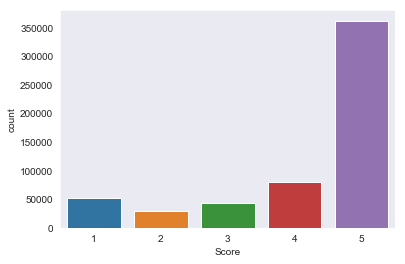

In [44]:
sns.countplot(df_score['Score'])

We have uneven distibution of scores, score 5 is much higher followed by 4 and 1 .

In [45]:
Score_helpnum=pd.DataFrame(df_score.groupby('Score')['HelpfulnessNumerator'].sum()).reset_index()
Score_helpnum.columns=['Score','Count']
Score_helpnum

Score   Count
0      1  140885
1      2   55321
2      3   72480
3      4  112081
4      5  607601

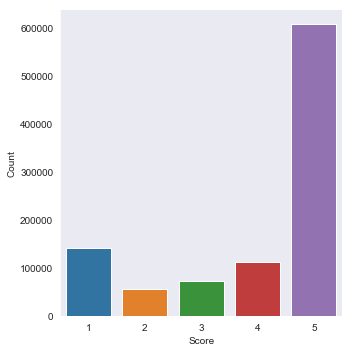

In [46]:
sns.catplot(x='Score',y='Count',data=Score_helpnum,kind='bar')

In [47]:
Score_helpden=pd.DataFrame(df_score.groupby('Score')['HelpfulnessDenominator'].sum()).reset_index()
Score_helpden.columns=['Score','Count']
Score_helpden

Score   Count
0      1  251213
1      2   92329
2      3  105074
3      4  134320
4      5  679667

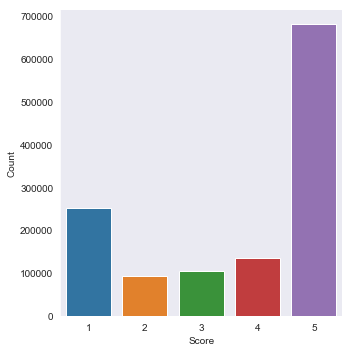

In [48]:
sns.catplot(x='Score',y='Count',data=Score_helpden,kind='bar')

In [49]:
Score_nothelp=pd.DataFrame(df_score.groupby('Score')['Not_helpfull'].sum()).reset_index()
Score_nothelp.columns=['Score','Count']
Score_nothelp

Score   Count
0      1  110328
1      2   37008
2      3   32594
3      4   22239
4      5   72066

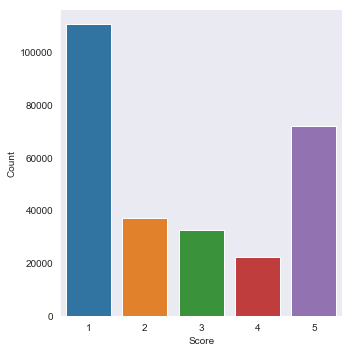

In [50]:
sns.catplot(x='Score',y='Count',data=Score_nothelp,kind='bar')

Thus from review useful and not useful plot what we understood that if a review is useful for other customer generally they go on to
buy the food item and thus scoring it 5. Many products for which review has not been found helpful has low score as customer has 
not bought that product may be they doybted the product.

In [51]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull'],
      dtype='object')

Lets check what is the score recieved by a product if it has high helpfulness.

In [52]:
data[['ProductId','HelpfulnessNumerator','HelpfulnessDenominator','Score']].sort_values(by='HelpfulnessNumerator',ascending=False).head(10)

ProductId  HelpfulnessNumerator  HelpfulnessDenominator  Score
190733  B000FI4O90                   866                     878      5
207712  B00012182G                   844                     923      3
566779  B001PQTYN2                   808                     815      5
235722  B001F10XUU                   580                     593      1
373575  B009K2BBQG                   559                     562      5
385450  B0051SU0OW                   559                     562      5
287184  B009K2BBT8                   559                     562      5
467800  B0065G59F4                   559                     562      5
297366  B0069GOKGE                   559                     562      5
293135  B008VQ01Y0                   559                     562      5

So from above what we see high review helpfulness means high score. Only 2 product are saying otherwise.

In [53]:
data[['ProductId','HelpfulnessNumerator','HelpfulnessDenominator','Score']].sort_values(by='HelpfulnessNumerator',ascending=True).head(10)

ProductId  HelpfulnessNumerator  HelpfulnessDenominator  Score
284254  B0051COPH6                     0                       0      5
322008  B0012V1G0Y                     0                       0      5
322007  B0012V1G0Y                     0                       0      5
322006  B0012V1G0Y                     0                       0      1
322005  B0012V1G0Y                     0                       0      1
322004  B0012V1G0Y                     0                       0      3
322003  B0012V1G0Y                     0                       0      5
322002  B0012V1G0Y                     0                       0      2
322001  B0012V1G0Y                     0                       0      5
322000  B0012V1G0Y                     0                       0      4

But from above what we can see that low review feedback doesn't mean low score.

In [54]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull'],
      dtype='object')

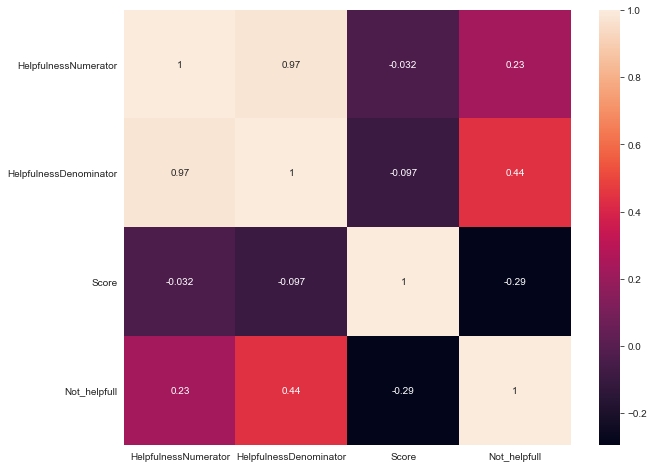

In [55]:
temp_df=data[['HelpfulnessNumerator','HelpfulnessDenominator','Score','Not_helpfull']]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

From the correlation matrix also we can see HelpfulnessDenominator and HelpfulnessNumerator are not that strongly related. But can 
find a strong -ve corelation between Score and Not_helpfull feature.

# TEXT

This text will be directly related to the score as  high score product will have positive reviews while the low score product will have -ve reviews.

1) will be checking the word clould based on the score , to understand what are the most prominent words used against each section.

2)We will be doing out feature engineering based on below categories:
    
    ##Direct features

    Features which are a directly due to words/content.We would be exploring the following techniques
    
    Word frequency features
    
    Count features
    
    Bigrams
    
    Trigrams
    
    Vector distance mapping of words (Eg: Word2Vec)
    
    Sentiment scores

3)Indirect features:

    count of sentences:
    
    count of words
    
    count of unique words
    
    count of letters
    
    count of punctuations
    
    count of uppercase words/letters
    
    count of stop words
    
    Avg length of each word
    
    Number of capitals :Dissatisfied customer can write in CAPS to express dissatisfaction.
    
    Number of exclamation marks 
    
    Number of question marks 
    
    Number of symbols
    
    Number of (happy) smilies :- Satisfied customer will use happy smilies.
    
    Length of the comment - my initial assumption is that angry people write short messages
    

# WORDCLOUD

Wordcloud for reveiws with score =5

In [56]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull'],
      dtype='object')

In [57]:
data["Text"]=data["Text"].apply(lambda x:x.replace('<br />',""))

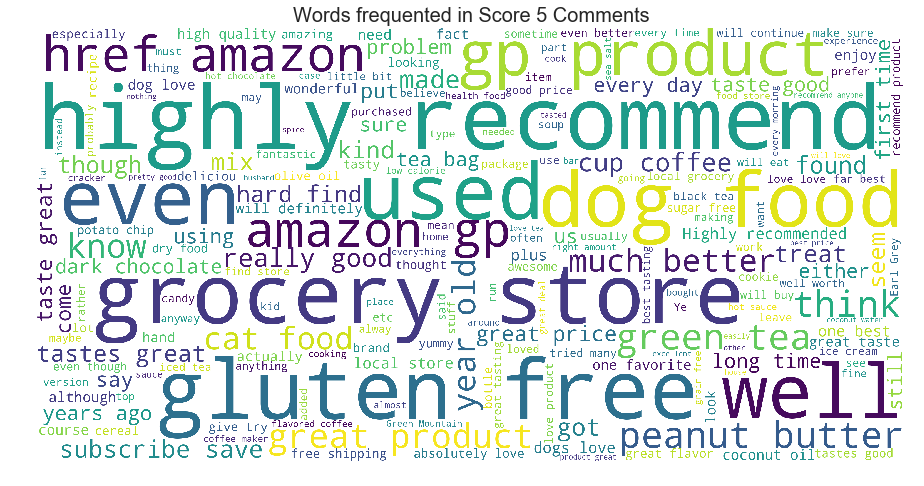

In [58]:
subset=data[data.Score==5]
Score5_corpus=' '.join(subset.Text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Score5_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in Score 5 Comments", fontsize=20)
plt.axis('off')
plt.show()

In [59]:
data[data['Text'].str.contains('br')]['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [60]:
data['Text_1']=data['Text'].apply(lambda x: str(x).split())

In [61]:
for i in data['Text_1']:
    for x in i:
        if x=='br':
            print(i)

In [62]:
data=data.drop(['Text_1'],axis=1)

"Highly recommend" ,gluten free are few words which customer thinks useful while buying , thus this have high scores too.

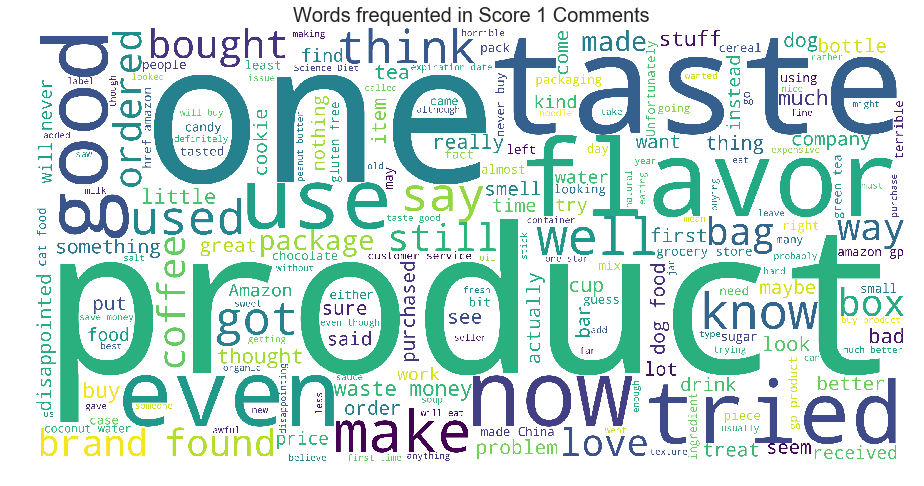

In [63]:
subset=data[data.Score==1]
Score1_corpus=' '.join(subset.Text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Score1_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in Score 1 Comments", fontsize=20)
plt.axis('off')
plt.show()

"Waste money","disappointed","tried" are kind of word which can be related to bad review , hence bad score. 

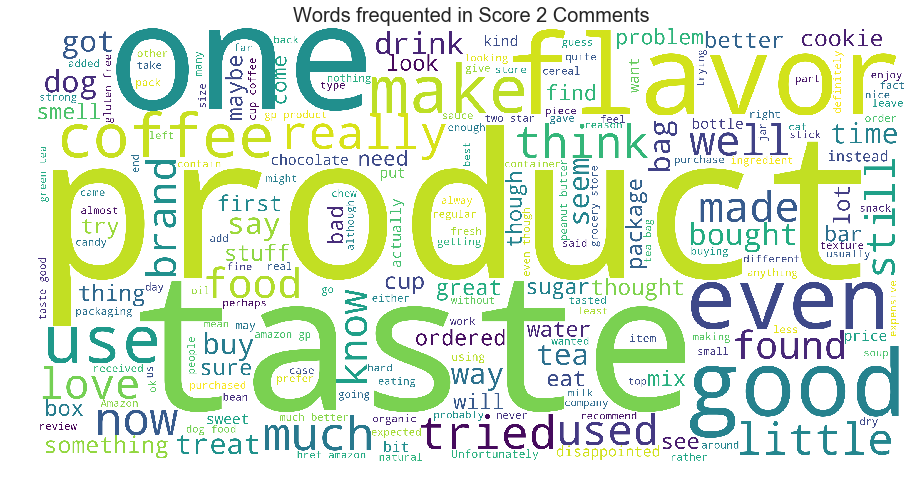

In [64]:
subset=data[data.Score==2]
Score2_corpus=' '.join(subset.Text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(Score2_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in Score 2 Comments", fontsize=20)
plt.axis('off')
plt.show()

Not much of useful information..Lets proceed further with indirect features.

In [65]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull'],
      dtype='object')

In [66]:
data['cnt_Sent']=data["Text"].apply(lambda x: len(re.findall('\n',str(x)))+1)

In [67]:
data['cnt_words']=data["Text"].apply(lambda x: len(str(x).split()))

In [68]:
data['unq_words']=data["Text"].apply(lambda x: len(set(str(x).split())))

In [69]:
data['cnt_lett']=data["Text"].apply(lambda x: len(str(x)))

In [70]:
data['cnt_punc']=data["Text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) 

In [71]:
j=0
for i in data["Text"][0]:
    if i in string.punctuation:
        j+=1
        print(j)

1
2
3


In [72]:
data['cnt_wrd_upper']=data["Text"].apply(lambda x: len([c for c in str(x).split() if c.isupper()])) 

In [73]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
data['cnt_wrd_title']=data["Text"].apply(lambda x: len([c for c in str(x).split() if c.istitle()])) 

In [75]:
data['cnt_stopwords']=data["Text"].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS])) 

In [76]:
data['mean_word_len']=data["Text"].apply(lambda x:np.mean([len(w) for w in str(x).split()])) 

In [77]:
data['mean_word_len'][0]

4.479166666666667

In [78]:
for i in data["Text"][0].split():
    if i in STOPWORDS:
        print(i)

have
of
the
and
have
them
all
to
be
of
more
like
a
than
a
and
it
is
and
she
this
than


In [79]:
data['cnt_wrd_upper'][0]

1

In [80]:
data['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [81]:
data['no.of_exclaim']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in "!"]))

In [82]:
data[data['no.of_exclaim']!=0]

Id   ProductId          UserId  \
362        363  B0041QJSJS  A2T68P9I05KBFT   
408        409  B001IZM8A6   AVI998S4IX2Y1   
577        578  B000G6RYNE  A1Q7A78VSQ5GQ4   
637        638  B000G6RYNE  A1J5HHOPXZ6UNF   
988        989  B006F2NYI2  A36WE3X9G0DZUZ   
1237      1238  B002G8N4ZW  A20S7XV2JK0UXL   
1261      1262  B001FA1L7A  A3JHTGEVR4714V   
1501      1502  B002KGN4LE  A253U7UEJQCVJI   
1613      1614  B001RVFDOO  A2Q92C2T5ODYM2   
1776      1777  B001RVFDOO  A3Q5YKYYGO5X1S   
1961      1962  B004H4R0YO  A2L3ATJQPPDJ86   
1999      2000  B001E5E29A   AZ9N3928BGQ0E   
2055      2056  B001E5E29A   AILO4OENJKQN1   
2501      2502  B0004MZVIA  A3ACTJ8H3RSW7C   
2804      2805  B000J2DQ46  A20IYCN35Z1DKM   
4047      4048  B000CMHMUC  A1ZG9SJ5BTZJ5W   
4114      4115  B001EW5YQS   AKCMNQW6YH6BL   
4530      4531  B002TMV3E4   ATLO3YXU2BC16   
4661      4662  B000FBM4FI  A1QF54LKDRD2HV   
4801      4802  B00139TT72  A3CU3YMUNKV0BO   
4911      4912  B0009JMW1C  A13V4Q16X7KQB2   
5326      5327  B000BYLQW6    AAUI9ZUQ5DSW   
5424      5425  B00622CYVS  A2YHXAZLCLDT8D   
5485      5486  B00622CYVI  A2YHXAZLCLDT8D   
5588      5589  B000G1X45G  A2OR94VN7XQCUO   
5707      5708  B004PEDM7K   AO2V7QN3JMF93   
5790      5791  B003TIVBSU  A2LY3UROLX4RVP   
5821      5822  B002HFRYZ0  A2ZY23X9IKXMON   
5969      5970  B001NVEJKC  A2KUY0DUFEQSOL   
6149      6150  B00370XQ5G  A3TOHDIBQSY04W   
...        ...         ...             ...   
562741  562742  B0009YJ4CW  A39G28MKPHZB97   
562893  562894  B0009YJ4CW  A2Y2N92VTDRR9H   
562912  562913  B0009YJ4CW    AFHIOZC7DNAI   
563052  563053  B007JFMH8M  A2K4ZSJPDAQCG1   
563114  563115  B007JFMH8M  A2LJGODTPOLNC8   
563140  563141  B007JFMH8M  A3CB563CBJS3U5   
563282  563283  B007JFMH8M  A1UJNBYW8L6N83   
563336  563337  B007JFMH8M  A3AJ7J3KB2LRVC   
563353  563354  B007JFMH8M   A8VCAYBU4YLUJ   
563449  563450  B007JFMH8M  A2RDJVM7WHUD1B   
563675  563676  B007JFMH8M  A15BBHB36Y8IEH   
563696  563697  B007JFMH8M  A1NNTRF2NMJS6C   
564092  564093  B002GWMCPG   AC9QTYA6GMYDH   
564109  564110  B000JMBE9U  A28DKY933U9EJI   
564119  564120  B006UM6D94  A21PPC77O01PG7   
564126  564127  B006UM6D94  A398XZFNW5R32A   
564201  564202  B005LMLZCO  A3H7DJ8TDWZTIC   
564538  564539  B002K74V3S    ACYR6O588USK   
564879  564880  B002EDIJL8  A1WK4YUCTFWS9A   
564894  564895  B002EDIJL8  A1KNFL9G04QLWO   
564936  564937  B003Q4TV5C  A3DZFHJ4B3Y23R   
565960  565961  B0009TILRG  A24T3UJHGBFJFT   
566725  566726  B002RMLZEY   A3XUGZZ9TZIYJ   
566894  566895  B006JGY91U   ABFO819UZDWS8   
566915  566916  B000H6UX0Y  A3VO9ITY9E1Y87   
567249  567250  B001FA1LF2  A2OHGDGN3IX854   
567258  567259  B003IMSFI6  A17L9OR8MOQ6IJ   
567388  567389  B000G6Q4FI  A1Q7A78VSQ5GQ4   
568221  568222  B0039CLK78  A3H2UIKQ9CEYKC   
568410  568411  B0018CLWM4   A88HLWDCU57WG   

                                         ProfileName  HelpfulnessNumerator  \
362                                             Rusy                     0   
408                   Melissa N. Connor "rare maven"                     1   
577                  Nice Lady "a reasonable person"                     4   
637                                            Chris                     0   
988                                           Gale P                     2   
1237                                 Gregory C. Ward                     1   
1261                                     marie james                     0   
1501                            Johanna Castano "JC"                     1   
1613                                    PowerGamer22                     0   
1776                 Sandra McNeil "Just a consumer"                     0   
1961                                       Willie P.                     0   
1999    J. Nachison "long-time SF and history lover"                     7   
2055                             Edward S. Pease Jr.                     0   
2501                       Mary Shelly "1951 VooDoo"               

In [83]:
data['Text'][362]

'Im learning that Latin American and South American coffees have this distinct "coffee" caramelish finish.  As a Peets Coffee fanatics we learned that Weavers roaster was the roaster for Peet\'s and we are hooked !  I already reviewd the French and Organic blend, but I must say this coffee here is a perfect afternoon drink.Met the weavers team at the Warner Brothers party and they gave me a half a pound of french roast.  Since them we are fans.You wont be dissapointed !'

In [84]:
data['no.of_exclaim'][362]

2

In [85]:
data['no.of_question']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in "?"]))

In [86]:
data['no.of_question']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in "?"]))

In [87]:
data['no.of_symb']=data["Text"].apply(lambda x:sum(x.count(w)for w in '*$&#%@'))

In [88]:
data['no.of_happy_smilies']=data["Text"].apply(lambda x:len([c for c in str(x).split() if c in (':-)', ':)', ';-)', ';)')]))

In [89]:
#derived features
#Word count percent in each comment:
data['word_unique_percent']=data['unq_words']*100/data['cnt_words']
#derived features
#Punct percent in each comment:
data['punct_percent']=data['cnt_punc']*100/data['cnt_words']

In [90]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'cnt_Sent', 'cnt_words', 'unq_words', 'cnt_lett',
       'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title', 'cnt_stopwords',
       'mean_word_len', 'no.of_exclaim', 'no.of_question', 'no.of_symb',
       'no.of_happy_smilies', 'word_unique_percent', 'punct_percent'],
      dtype='object')

Let us check the correlation matrix of all the features we just created with the Score. We can understnad how useful this features really are

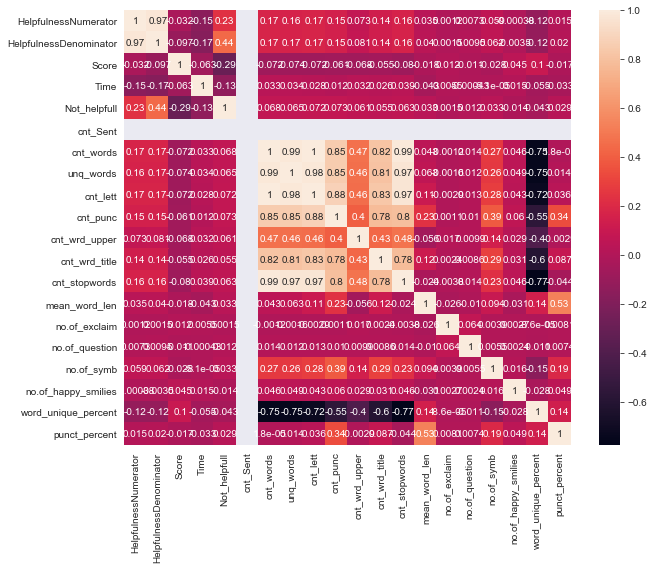

In [91]:
temp_df=data[['HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'cnt_Sent', 'cnt_words', 'unq_words', 'cnt_lett',
       'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title', 'cnt_stopwords',
       'mean_word_len', 'no.of_exclaim', 'no.of_question', 'no.of_symb',
       'no.of_happy_smilies','word_unique_percent', 'punct_percent']]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [92]:
print("Find most important features relative to target")
corr =temp_df.corr()
corr.sort_values(["Score"], ascending = False, inplace = True)
corr
print(corr['Score'])

Find most important features relative to target
Score                     1.000000
word_unique_percent       0.102795
no.of_happy_smilies       0.045413
no.of_exclaim             0.012120
no.of_question           -0.010942
punct_percent            -0.017236
mean_word_len            -0.017674
no.of_symb               -0.028349
HelpfulnessNumerator     -0.031762
cnt_wrd_title            -0.054661
cnt_punc                 -0.061115
Time                     -0.063063
cnt_wrd_upper            -0.067501
cnt_words                -0.071692
cnt_lett                 -0.072407
unq_words                -0.074455
cnt_stopwords            -0.080086
HelpfulnessDenominator   -0.096820
Not_helpfull             -0.294304
cnt_Sent                       NaN
Name: Score, dtype: float64


In [93]:
temp_df['cnt_Sent'].value_counts()

1    567554
Name: cnt_Sent, dtype: int64

Most of the features has corelation less than 0.05 other than word_uniqur percent and Not_helpful , have low significance. Let's move forward and convert words to token and then
we will obtain the vectorizer using TF-IDF or count vecotorizer.

In [94]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [95]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [96]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'cnt_Sent', 'cnt_words', 'unq_words', 'cnt_lett',
       'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title', 'cnt_stopwords',
       'mean_word_len', 'no.of_exclaim', 'no.of_question', 'no.of_symb',
       'no.of_happy_smilies', 'word_unique_percent', 'punct_percent'],
      dtype='object')

In [97]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data['Text'].values):
    # remove urls from text python
    sentance = re.sub(r"http\S+", "", sentance)
    #python-beautifulsoup-how-to-remove-all-tags-from-an-element
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    #remove words with numbers python
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #remove spacial character
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    
    #sentance=[lem.lemmatize(word, "v") for word in sentance]
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 567554/567554 [07:08<00:00, 1325.60it/s]


In [98]:
preprocessed_reviews=[lem.lemmatize(word, "v") for word in preprocessed_reviews]

# Featurization


# BAG OF WORDS


In [99]:
preprocessed_reviews

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted not sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven not chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces

In [100]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:20])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaah', 'aaaaaahhh']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (567554, 121873)
the number of unique words  121873


In [101]:
print("some feature names ", count_vect.get_feature_names()[:1000])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaacccccccckkkkkk', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaah', 'aaaaaahhh', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhyaaaaaa', 'aaaaaand', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaaallll', 'aaaaawsome', 'aaaah', 'aaaahhhhhh', 'aaaahhhhhhhhhhh', 'aaaallll', 'aaaand', 'aaaannnnddd', 'aaaarrrrghh', 'aaagh', 'aaah', 'aaahhh', 'aaahhhhhh', 'aaahhhs', 'aaahs', 'aabout', 'aabsolutely', 'aachen', 'aachener', 'aacurate', 'aad', 'aadd', 'aadmit', 'aadp', 'aadults', 'aaf', 'aafco', 'aafes', 'aafter', 'aagh', 'aagreen', 'aah', 'aahhed', 'aahhhs', 'aahing', 'aahs', 'aain', 'aalmost', 'aaloo', 'aalouisiana', 'aamazon', 'aamzon', 'aana', 'aand', 'aanother', 'aany', 'aap', 'aardvark', 'aare', 'aargh', '

# Bi-Grams and n-Grams.


In [102]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (567554, 5000)
the number of unique words including both unigrams and bigrams  5000


In [103]:
count_vect.get_feature_names()[:1000]

['ability',
 'able',
 'able buy',
 'able find',
 'able get',
 'absolute',
 'absolute favorite',
 'absolutely',
 'absolutely delicious',
 'absolutely love',
 'absolutely loves',
 'absolutely no',
 'acai',
 'acceptable',
 'access',
 'accident',
 'according',
 'account',
 'accurate',
 'acid',
 'acidic',
 'acidity',
 'acids',
 'acquired',
 'across',
 'active',
 'actual',
 'actually',
 'actually taste',
 'actually tastes',
 'add',
 'add little',
 'add sugar',
 'add water',
 'added',
 'added bonus',
 'added sugar',
 'addict',
 'addicted',
 'addicting',
 'addiction',
 'addictive',
 'adding',
 'addition',
 'additional',
 'additives',
 'address',
 'adds',
 'adjust',
 'admit',
 'adopted',
 'adore',
 'adult',
 'adults',
 'advantage',
 'advertised',
 'advertising',
 'advice',
 'affect',
 'afford',
 'affordable',
 'afraid',
 'afternoon',
 'aftertaste',
 'aftertaste not',
 'afterwards',
 'agave',
 'agave nectar',
 'age',
 'ages',
 'ago',
 'agree',
 'agreed',
 'ahead',
 'ahoy',
 'aid',
 'air',
 'al',

# TF-IDF


In [104]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaah', 'aafco', 'aah', 'aahing', 'ab', 'ab work']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (567554, 358018)
the number of unique words including both unigrams and bigrams  358018


# Word2Vec


In [105]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [106]:
list_of_sentance

[['bought',
  'several',
  'vitality',
  'canned',
  'dog',
  'food',
  'products',
  'found',
  'good',
  'quality',
  'product',
  'looks',
  'like',
  'stew',
  'processed',
  'meat',
  'smells',
  'better',
  'labrador',
  'finicky',
  'appreciates',
  'product',
  'better'],
 ['product',
  'arrived',
  'labeled',
  'jumbo',
  'salted',
  'peanuts',
  'peanuts',
  'actually',
  'small',
  'sized',
  'unsalted',
  'not',
  'sure',
  'error',
  'vendor',
  'intended',
  'represent',
  'product',
  'jumbo'],
 ['confection',
  'around',
  'centuries',
  'light',
  'pillowy',
  'citrus',
  'gelatin',
  'nuts',
  'case',
  'filberts',
  'cut',
  'tiny',
  'squares',
  'liberally',
  'coated',
  'powdered',
  'sugar',
  'tiny',
  'mouthful',
  'heaven',
  'not',
  'chewy',
  'flavorful',
  'highly',
  'recommend',
  'yummy',
  'treat',
  'familiar',
  'story',
  'c',
  'lewis',
  'lion',
  'witch',
  'wardrobe',
  'treat',
  'seduces',
  'edmund',
  'selling',
  'brother',
  'sisters',
  

In [107]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8758031129837036), ('good', 0.8700398802757263), ('awesome', 0.8666157722473145), ('terrific', 0.8647408485412598), ('excellent', 0.8463782072067261), ('wonderful', 0.814875602722168), ('perfect', 0.7832992076873779), ('nice', 0.7532333135604858), ('amazing', 0.748564600944519), ('fabulous', 0.7380898594856262)]
[('nastiest', 0.8213152289390564), ('greatest', 0.7785390019416809), ('weakest', 0.7457800507545471), ('horrid', 0.7406184077262878), ('nicest', 0.7227845788002014), ('best', 0.7227752208709717), ('disgusting', 0.7224459052085876), ('foulest', 0.7131056785583496), ('horrible', 0.7052380442619324), ('terrible', 0.6956946849822998)]


In [108]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  41504
sample words  ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'error', 'vendor', 'intended', 'represent', 'confection', 'around', 'centuries', 'light', 'pillowy', 'citrus', 'gelatin', 'nuts', 'case', 'filberts', 'cut', 'tiny', 'squares', 'liberally']


# Converting text into vectors using wAvg W2V, TFIDF-W2V


# Avg W2v


In [109]:
list_of_sentance

[['bought',
  'several',
  'vitality',
  'canned',
  'dog',
  'food',
  'products',
  'found',
  'good',
  'quality',
  'product',
  'looks',
  'like',
  'stew',
  'processed',
  'meat',
  'smells',
  'better',
  'labrador',
  'finicky',
  'appreciates',
  'product',
  'better'],
 ['product',
  'arrived',
  'labeled',
  'jumbo',
  'salted',
  'peanuts',
  'peanuts',
  'actually',
  'small',
  'sized',
  'unsalted',
  'not',
  'sure',
  'error',
  'vendor',
  'intended',
  'represent',
  'product',
  'jumbo'],
 ['confection',
  'around',
  'centuries',
  'light',
  'pillowy',
  'citrus',
  'gelatin',
  'nuts',
  'case',
  'filberts',
  'cut',
  'tiny',
  'squares',
  'liberally',
  'coated',
  'powdered',
  'sugar',
  'tiny',
  'mouthful',
  'heaven',
  'not',
  'chewy',
  'flavorful',
  'highly',
  'recommend',
  'yummy',
  'treat',
  'familiar',
  'story',
  'c',
  'lewis',
  'lion',
  'witch',
  'wardrobe',
  'treat',
  'seduces',
  'edmund',
  'selling',
  'brother',
  'sisters',
  

In [110]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance[0:5000]): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 375.87it/s]

5000
50


In [111]:
sent_vec

array([-0.72603955, -0.66869108, -0.74119411, -0.34295387,  1.02848423,
        0.02851976, -0.43099294, -0.37976669,  0.96233649,  0.18523095,
       -0.53160659,  0.44186528,  0.02432064, -0.75416117,  0.10766716,
       -0.02438799,  0.12873303, -0.59461191, -1.1292169 , -0.27733661,
       -0.25232451,  0.43849739, -0.7698256 ,  0.23784002, -0.19035738,
        0.67542149, -1.46248686, -0.29521341,  0.34301481, -0.12347126,
        0.54760347, -0.12614458, -0.96650307,  0.72464907, -1.75486166,
       -0.3892421 ,  1.22734607, -0.37590135,  0.40470408, -0.10435482,
        0.0719878 ,  0.47677209, -0.50146312, -0.12927092, -1.6509089 ,
       -1.14311914,  0.27416893, -0.27167934, -0.25592867,  0.67698764])

# TFIDF weighted W2v

In [112]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [113]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance[0:5000]): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:52<00:00,  6.47it/s]


# Applying TNSE on Text BOW vectors


In [114]:
list_of_sentance[0:5000]

[['bought',
  'several',
  'vitality',
  'canned',
  'dog',
  'food',
  'products',
  'found',
  'good',
  'quality',
  'product',
  'looks',
  'like',
  'stew',
  'processed',
  'meat',
  'smells',
  'better',
  'labrador',
  'finicky',
  'appreciates',
  'product',
  'better'],
 ['product',
  'arrived',
  'labeled',
  'jumbo',
  'salted',
  'peanuts',
  'peanuts',
  'actually',
  'small',
  'sized',
  'unsalted',
  'not',
  'sure',
  'error',
  'vendor',
  'intended',
  'represent',
  'product',
  'jumbo'],
 ['confection',
  'around',
  'centuries',
  'light',
  'pillowy',
  'citrus',
  'gelatin',
  'nuts',
  'case',
  'filberts',
  'cut',
  'tiny',
  'squares',
  'liberally',
  'coated',
  'powdered',
  'sugar',
  'tiny',
  'mouthful',
  'heaven',
  'not',
  'chewy',
  'flavorful',
  'highly',
  'recommend',
  'yummy',
  'treat',
  'familiar',
  'story',
  'c',
  'lewis',
  'lion',
  'witch',
  'wardrobe',
  'treat',
  'seduces',
  'edmund',
  'selling',
  'brother',
  'sisters',
  

In [115]:
x=final_counts[:500,:]

In [116]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'cnt_Sent', 'cnt_words', 'unq_words', 'cnt_lett',
       'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title', 'cnt_stopwords',
       'mean_word_len', 'no.of_exclaim', 'no.of_question', 'no.of_symb',
       'no.of_happy_smilies', 'word_unique_percent', 'punct_percent'],
      dtype='object')

In [117]:
label=data['Score'][:500]

In [118]:
label.unique()

array([5, 1, 4, 2, 3], dtype=int64)

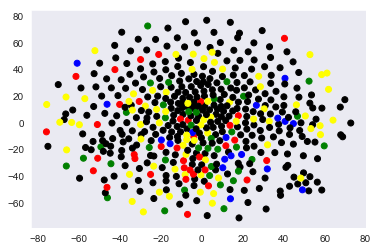

In [119]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

#iris = datasets.load_iris()
#x = iris['data']
y = label

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {1:'red', 2:'blue', 3:'green',4:'yellow',5:'black'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

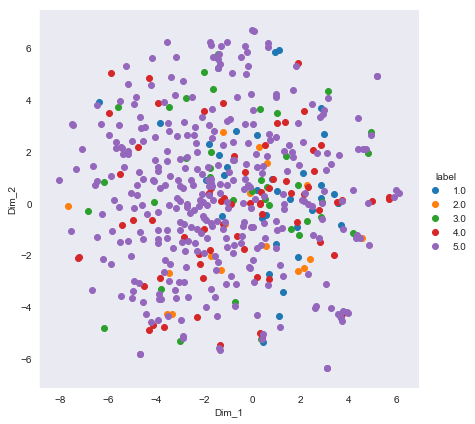

In [120]:
# TSNE

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = final_counts[0:500,:].toarray()
labels_1000 = label[0:500]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Applying TNSE on Text TFIDF vectors


In [121]:
final_tf_idf.shape

(567554, 358018)

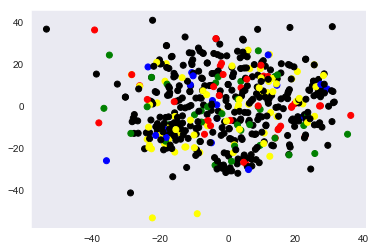

In [122]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

#iris = datasets.load_iris()
x = final_tf_idf[:500]
y = label

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {1:'red', 2:'blue', 3:'green',4:'yellow',5:'black'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

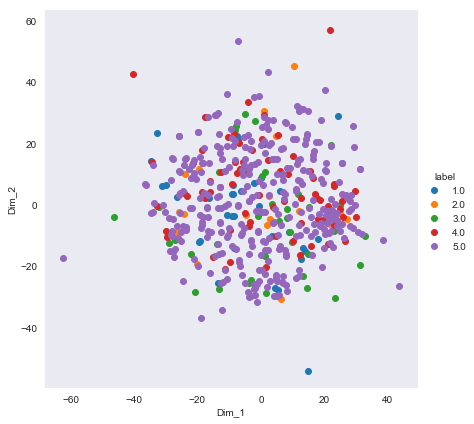

In [123]:
# TSNE

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = final_tf_idf[0:500,:].toarray()
labels_1000 = label[0:500]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [124]:
w2v_model.wv.vocab

{'bought': <gensim.models.keyedvectors.Vocab at 0x1e9b16ef828>,
 'several': <gensim.models.keyedvectors.Vocab at 0x1e9b16ef898>,
 'vitality': <gensim.models.keyedvectors.Vocab at 0x1eaa0c008d0>,
 'canned': <gensim.models.keyedvectors.Vocab at 0x1eaa0c00d68>,
 'dog': <gensim.models.keyedvectors.Vocab at 0x1eaa103d278>,
 'food': <gensim.models.keyedvectors.Vocab at 0x1eaa103d2b0>,
 'products': <gensim.models.keyedvectors.Vocab at 0x1eaa111e160>,
 'found': <gensim.models.keyedvectors.Vocab at 0x1eaa1178400>,
 'good': <gensim.models.keyedvectors.Vocab at 0x1eaa11d27b8>,
 'quality': <gensim.models.keyedvectors.Vocab at 0x1eaa11d27f0>,
 'product': <gensim.models.keyedvectors.Vocab at 0x1eaa11d2828>,
 'looks': <gensim.models.keyedvectors.Vocab at 0x1eaa11d2860>,
 'like': <gensim.models.keyedvectors.Vocab at 0x1eaa11d2898>,
 'stew': <gensim.models.keyedvectors.Vocab at 0x1eaa11d28d0>,
 'processed': <gensim.models.keyedvectors.Vocab at 0x1eaa11d2908>,
 'meat': <gensim.models.keyedvectors.Vocab 

In [125]:
sent_vectors

[array([-0.28027588,  0.27999674,  0.02975757, -0.76176263, -0.27405138,
         1.31477418,  0.1129559 , -0.82826156, -0.21352154, -1.03644421,
        -0.73073069,  0.58947498,  0.43112624, -0.47928068, -1.38076752,
         2.03035459, -0.66673899,  0.53629167, -0.94893654,  0.61514447,
        -1.06502631,  0.25658989,  0.53657714, -0.56198327, -0.1998897 ,
         0.68689252, -0.93664301,  0.01207207, -0.20567227, -0.57975227,
         0.2571396 ,  0.1549296 , -2.15033939,  1.13256522, -0.42384795,
         0.20258314, -0.02172622, -0.74553307, -0.28429761,  0.86943826,
         1.26477869,  0.80799056, -1.14561356, -0.90707014, -0.37104048,
        -0.96984887,  0.21986258, -0.17512613,  0.17856538,  0.58363967]),
 array([-0.72809938, -0.2296649 , -0.35933351, -1.21591715,  0.4569046 ,
         0.66736106,  0.72431303, -0.11653626,  0.58619905,  0.81531807,
        -1.0398436 ,  0.24825832,  0.56634702, -0.06722411,  1.83951203,
         1.60785682, -0.85553532,  0.15431498, -1

# Applying TNSE on Text Avg W2V vectors


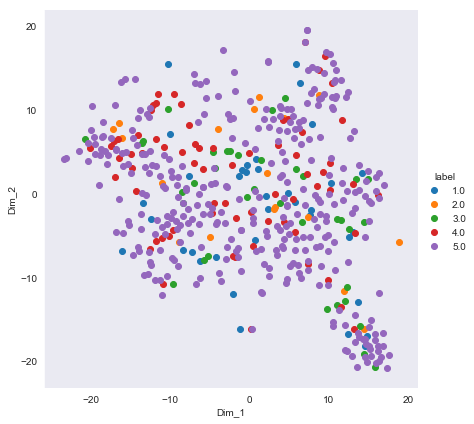

In [126]:
# TSNE

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = sent_vectors[0:500]
labels_1000 = label[0:500]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Applying TNSE on Text TFIDF weighted W2V vectors


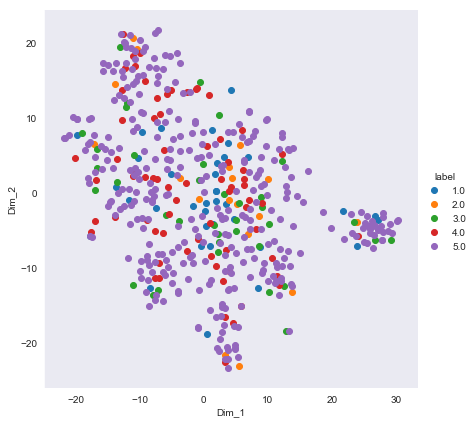

In [127]:
# TSNE

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = tfidf_sent_vectors[0:500]
labels_1000 = label[0:500]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [136]:
#Storing the BOW
import pickle
pickle_1=open("dict1.pickle","wb")
pickle.dump(final_counts, pickle_1)
pickle_1.close()

pickle_2=open("dict2.pickle","wb")
pickle.dump(final_tf_idf, pickle_2)
pickle_2.close()

pickle_3=open("dict3.pickle","wb")
pickle.dump(sent_vectors, pickle_3)
pickle_3.close()

pickle_4=open("dict4.pickle","wb")
pickle.dump(tfidf_sent_vectors, pickle_4)
pickle_4.close()

In [131]:
final_counts.shape

(567554, 121873)

In [132]:
final_tf_idf.shape

(567554, 358018)

In [137]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Not_helpfull', 'cnt_Sent', 'cnt_words', 'unq_words', 'cnt_lett',
       'cnt_punc', 'cnt_wrd_upper', 'cnt_wrd_title', 'cnt_stopwords',
       'mean_word_len', 'no.of_exclaim', 'no.of_question', 'no.of_symb',
       'no.of_happy_smilies', 'word_unique_percent', 'punct_percent'],
      dtype='object')

In [138]:
pickle_5=open("dict5.pickle","wb")
pickle.dump(data, pickle_5)
pickle_5.close()

In [ ]:
pickle_6=open("dict6.pickle","wb")
pickle.dump(preprocessed_reviews, pickle_6)
pickle_6.close()